# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch

# Set colour palette

In [ ]:
# Atlassian Brand Colours
atlassian_colors = [
    "#0052CC",  # Atlassian Blue (primary)
    "#2684FF",  # Bright Blue
    "#57D9A3",  # Green accent
    "#FFAB00",  # Gold accent
    "#FF5630",  # Red accent
    "#36B37E",  # Secondary green
    "#6554C0"   # Purple accent
]

# Set Global Theme
sns.set_theme(
    style="whitegrid",
    palette=atlassian_colors,
    rc={
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.edgecolor": "#DFE1E6",
        "axes.linewidth": 1.0,
        "axes.facecolor": "white",
        "figure.facecolor": "white"
    }
)

# Import Datasets

In [3]:
billing_df = pd.read_csv('../datasets/billing.csv')
events_df = pd.read_csv('../datasets/events.csv')
sessions_df = pd.read_csv('../datasets/sessions.csv')
users_df = pd.read_csv('../datasets/users.csv')


# Merge Datasets

In [4]:
# Datetime format
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'], errors='coerce')
events_df['ts'] = pd.to_datetime(events_df['ts'], errors='coerce')

sessions_agg_user = sessions_df.groupby("user_id").agg(
    total_sessions=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean"),
    total_session_length=("session_length_sec", "sum"),
    most_common_device=("device", lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_os=("os", lambda x: x.mode()[0] if not x.mode().empty else None),
).reset_index()

# Add monthly aggregation for user-month dataset
sessions_agg_month = sessions_df.groupby(["user_id", sessions_df["session_start"].dt.to_period("M")]).agg(
    total_sessions=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean"),
    total_session_length=("session_length_sec", "sum")
).reset_index().rename(columns={"session_start": "month"})
sessions_agg_month["month"] = sessions_agg_month["month"].astype(str)

# Aggregate events
events_agg_user = events_df.groupby("user_id").agg(
    total_events=("event_id", "count"),
    avg_event_duration=("duration_ms", "mean"),
    avg_latency=("latency_ms", "mean"),
    success_rate=("success", "mean")
).reset_index()

events_agg_month = events_df.groupby(["user_id", events_df["ts"].dt.to_period("M")]).agg(
    total_events=("event_id", "count"),
    avg_event_duration=("duration_ms", "mean"),
    avg_latency=("latency_ms", "mean"),
    success_rate=("success", "mean")
).reset_index().rename(columns={"ts": "month"})
events_agg_month["month"] = events_agg_month["month"].astype(str)

# Billing aggregation
billing_agg_user = billing_df.groupby("user_id").agg(
    avg_mrr=("mrr", "mean"),
    total_mrr=("mrr", "sum"),
    max_mrr=("mrr", "max"),
    avg_active_seats=("active_seats", "mean"),
    total_support_tickets=("support_ticket_count", "sum"),
    invoices_overdue=("invoices_overdue", "sum"),
    discount_used=("discount_applied", "sum")
).reset_index()

# User level dataset
user_level = (
    users_df
    .merge(sessions_agg_user, on="user_id", how="left")
    .merge(events_agg_user, on="user_id", how="left")
    .merge(billing_agg_user, on="user_id", how="left")
)

# User month dataset
user_month = (
    billing_df
    .merge(users_df, on="user_id", how="left")
    .merge(sessions_agg_month, on=["user_id", "month"], how="left")
    .merge(events_agg_month, on=["user_id", "month"], how="left")
)

In [6]:
user_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                100000 non-null  object 
 1   signup_date            100000 non-null  object 
 2   plan_tier              100000 non-null  object 
 3   company_size           100000 non-null  object 
 4   region                 61776 non-null   object 
 5   industry               100000 non-null  object 
 6   acquisition_channel    100000 non-null  object 
 7   is_enterprise          100000 non-null  bool   
 8   churned_30d            100000 non-null  int64  
 9   churned_90d            100000 non-null  int64  
 10  downgraded             100000 non-null  int64  
 11  expansion_event        100000 non-null  int64  
 12  total_sessions         71533 non-null   float64
 13  avg_session_length     71533 non-null   float64
 14  total_session_length   71533 non-null

In [5]:
user_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000176 entries, 0 to 1000175
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   user_id               1000176 non-null  object 
 1   month                 1000176 non-null  object 
 2   plan_tier_x           1000176 non-null  object 
 3   active_seats          1000176 non-null  int64  
 4   mrr                   1000176 non-null  float64
 5   discount_applied      1000176 non-null  int64  
 6   invoices_overdue      1000176 non-null  int64  
 7   support_ticket_count  1000176 non-null  int64  
 8   signup_date           1000176 non-null  object 
 9   plan_tier_y           1000176 non-null  object 
 10  company_size          1000176 non-null  object 
 11  region                618324 non-null   object 
 12  industry              1000176 non-null  object 
 13  acquisition_channel   1000176 non-null  object 
 14  is_enterprise         1000176 non-

# Feature Engineering

In [8]:
# convert types
user_month = user_month.copy()
user_month["month"] = pd.to_datetime(user_month["month"])
user_month["signup_date"] = pd.to_datetime(user_month["signup_date"])
user_month["is_enterprise"] = user_month["is_enterprise"].astype(int)

# sort for group operations
user_month = user_month.sort_values(["user_id","month"])

# tenure, lagged mrr, differences
user_month["tenure_days"] = (user_month["month"] - user_month["signup_date"]).dt.days.clip(lower=0)
user_month["prev_mrr"] = user_month.groupby("user_id")["mrr"].shift(1).fillna(0.0)
user_month["mrr_diff"] = user_month["mrr"] - user_month["prev_mrr"]

# cumulative mrr stats
user_month["total_mrr"] = user_month.groupby("user_id")["mrr"].cumsum()
user_month["avg_mrr"] = (
    user_month.groupby("user_id")["total_mrr"]
    .transform(lambda x: x / np.arange(1, len(x)+1))
)
user_month["max_mrr"] = user_month.groupby("user_id")["mrr"].cummax()

# session and event ratios
user_month["events_per_session"] = (
    user_month["total_events"] / user_month["total_sessions"].replace({0:np.nan})
).fillna(0)
user_month["sessions_per_month"] = user_month["total_sessions"].fillna(0)

# seat and billing features
user_month["mrr_per_seat"] = (
    user_month["mrr"] / user_month["active_seats"].replace({0:np.nan})
).fillna(0)
user_month["avg_active_seats"] = user_month.groupby("user_id")["active_seats"].transform("mean")
user_month["discount_used"] = user_month["discount_applied"]

# categorical cleanup
user_month = user_month.rename(columns={"plan_tier_x": "plan"})
user_month["plan"] = user_month["plan"].astype("string").fillna("missing")
user_month["region"] = user_month["region"].astype("string").fillna("missing")
user_month["acquisition_channel"] = user_month["acquisition_channel"].astype("string").fillna("missing")
user_month["most_common_device"] = "missing"
user_month["most_common_os"] = "missing"

# target label
user_month["target"] = user_month["expansion_event"].astype(int)


Transforms the raw user_month table into a training-ready dataset for MLP model. It standardises datatypes, orders each user’s records chronologically, and engineers features that capture account progression over time. These include tenure in days, previous month revenue and differences, cumulative, average, and maximum MRR, as well as ratios such as events per session and revenue per seat. It also derives aggregated seat and billing metrics, cleans categorical fields like plan, region, and acquisition channel, and inserts placeholders for device and OS columns expected by the model. Finally, it generates a binary target column from the expansion event label, producing an enriched dataset with all required numeric and categorical features for training.

# Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

# numeric and categorical features expected by the model
num_feats = [
    'mrr','prev_mrr','mrr_diff','avg_mrr','total_mrr','max_mrr',
    'total_sessions','total_session_length','avg_session_length',
    'total_events','avg_event_duration','avg_latency','events_per_session',
    'sessions_per_month','avg_active_seats','support_ticket_count',
    'invoices_overdue','discount_used','tenure_days','mrr_per_seat'
]

cat_feats = ['most_common_device','most_common_os','plan','region','acquisition_channel','is_enterprise']

# keep only rows where target is defined
mask = ~user_month["target"].isna()
X = user_month[num_feats + cat_feats].loc[mask].reset_index(drop=True)
y = user_month["target"].loc[mask].reset_index(drop=True)

# stratify keeps the same 0/1 ratio in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

 80% allocated for training and 20% reserved for evaluation. This approach is a straightforward hold-out validation, rather than cross-validation, which would involve multiple train–test folds averaged together. The split was stratified, meaning the ratio of expansion to non-expansion cases was kept consistent in both the training and testing sets, ensuring class balance is preserved during model development and evaluation.

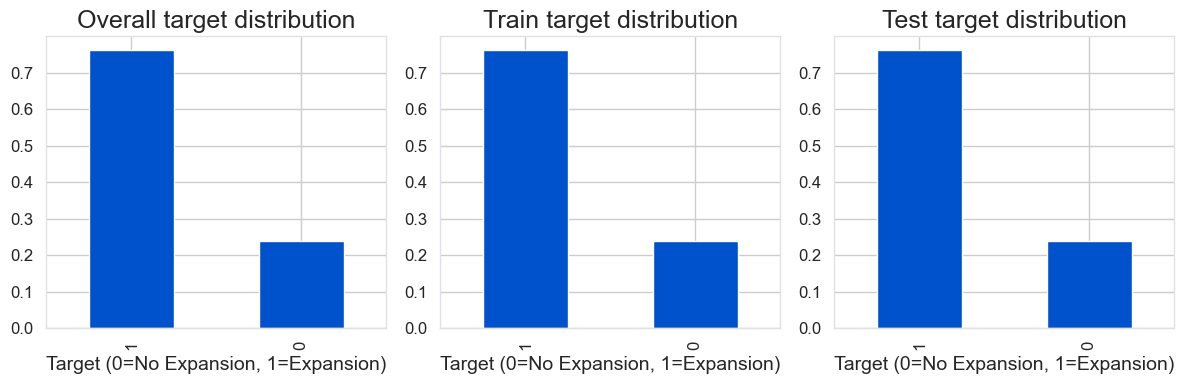

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

y.value_counts(normalize=True).plot(kind="bar", ax=ax[0], title="Overall target distribution")
y_train.value_counts(normalize=True).plot(kind="bar", ax=ax[1], title="Train target distribution")
y_test.value_counts(normalize=True).plot(kind="bar", ax=ax[2], title="Test target distribution")

for a in ax: a.set_xlabel("Target (0=No Expansion, 1=Expansion)")
plt.tight_layout()
plt.show()


# Feature Preprocessing

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", ohe)
])

pre = ColumnTransformer([
    ("num", num_pipe, num_feats),
    ("cat", cat_pipe, cat_feats)
])

pre.fit(X_train)
Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)


# Tensors

In [12]:
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xt_train = torch.tensor(Xtr.astype("float32")).to(device)
yt_train = torch.tensor(y_train.values.astype("float32")).unsqueeze(1).to(device)
Xt_test  = torch.tensor(Xte.astype("float32")).to(device)
yt_test  = torch.tensor(y_test.values.astype("float32")).unsqueeze(1).to(device)

train_loader = DataLoader(TensorDataset(Xt_train, yt_train), batch_size=1024, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xt_test, yt_test), batch_size=1024, shuffle=False)


This block converts the preprocessed NumPy arrays into PyTorch tensors, moves them to GPU (if available), and organizes them into DataLoader objects. The TensorDataset pairs each row of features with its label, while the DataLoader splits the dataset into mini-batches (here 1024 samples each) for efficient training. Training data is shuffled each epoch to prevent order bias, while test data is kept in order for consistent evaluation.

# Define Model

In [13]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden=[256,128], dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP(Xtr.shape[1]).to(device)


For this dataset, which has over a million user-month rows and around a few dozen engineered features, the chosen architecture strikes a balance between capacity and generalization. Two hidden layers (256 and 128 units) give the network enough flexibility to capture non-linear relationships in customer behaviour (like how sessions, billing, and seats interact) without becoming excessively deep and hard to train. Batch normalization helps stabilise training across such a large dataset, while dropout at 30% reduces the risk of overfitting to specific patterns in certain user segments. The final single output is appropriate since you’re predicting a binary expansion event (yes/no). This setup is powerful enough to learn from the scale of your data while remaining efficient to train on GPU.

In [14]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, classification_report
import time

# count class balance for pos_weight
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
if pos > 0:
    pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# convert arrays to tensors
Xt_train = torch.tensor(Xtr.astype("float32"))
yt_train = torch.tensor(y_train.values.astype("float32")).unsqueeze(1)
Xt_test  = torch.tensor(Xte.astype("float32"))
yt_test  = torch.tensor(y_test.values.astype("float32")).unsqueeze(1)

# dataloaders
train_loader = DataLoader(TensorDataset(Xt_train, yt_train), batch_size=1024, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xt_test, yt_test), batch_size=1024, shuffle=False)

# training loop
epochs = 20
best_auc, best_state = 0.0, None

for ep in range(1, epochs+1):
    model.train()
    epoch_loss, t0 = 0.0, time.time()
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    
    # evaluation on test set
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_probs.extend(probs)
            all_labels.extend(yb.numpy().ravel())
    
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float("nan")
    if auc > best_auc:
        best_auc, best_state = auc, model.state_dict()
    print(f"Epoch {ep}/{epochs} | Loss={epoch_loss:.4f} | Test AUC={auc:.4f} | Time={time.time()-t0:.1f}s")

# reload best model
if best_state is not None:
    model.load_state_dict(best_state)

# final evaluation
model.eval()
probs, labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs.extend(torch.sigmoid(logits).cpu().numpy().ravel())
        labels.extend(yb.numpy().ravel())

preds = (np.array(probs) >= 0.5).astype(int)
print("Final Test ROC AUC:", roc_auc_score(labels, probs))
print("Classification Report:")
print(classification_report(labels, preds, zero_division=0))


Epoch 1/20 | Loss=0.1766 | Test AUC=0.9258 | Time=63.8s
Epoch 2/20 | Loss=0.1663 | Test AUC=0.9273 | Time=45.2s
Epoch 3/20 | Loss=0.1646 | Test AUC=0.9286 | Time=33.7s
Epoch 4/20 | Loss=0.1632 | Test AUC=0.9306 | Time=36.3s
Epoch 5/20 | Loss=0.1617 | Test AUC=0.9323 | Time=33.5s
Epoch 6/20 | Loss=0.1604 | Test AUC=0.9340 | Time=42.9s
Epoch 7/20 | Loss=0.1592 | Test AUC=0.9356 | Time=41.0s
Epoch 8/20 | Loss=0.1568 | Test AUC=0.9382 | Time=38.7s
Epoch 9/20 | Loss=0.1542 | Test AUC=0.9412 | Time=44.2s
Epoch 10/20 | Loss=0.1523 | Test AUC=0.9421 | Time=37.4s
Epoch 11/20 | Loss=0.1504 | Test AUC=0.9460 | Time=38.1s
Epoch 12/20 | Loss=0.1483 | Test AUC=0.9480 | Time=44.1s
Epoch 13/20 | Loss=0.1470 | Test AUC=0.9486 | Time=40.3s
Epoch 14/20 | Loss=0.1457 | Test AUC=0.9492 | Time=40.7s
Epoch 15/20 | Loss=0.1449 | Test AUC=0.9512 | Time=60.5s
Epoch 16/20 | Loss=0.1440 | Test AUC=0.9500 | Time=47.8s
Epoch 17/20 | Loss=0.1437 | Test AUC=0.9527 | Time=146.1s
Epoch 18/20 | Loss=0.1424 | Test AUC=0.

A weighted binary cross-entropy loss is used to handle class imbalance, with pos_weight ensuring the model doesn’t ignore the minority class. The optimizer (Adam) updates network weights using mini-batches of size 1024 for 20 epochs. After each epoch, the model is evaluated on the test set using ROC AUC, and the best-performing state is saved. Finally, the model is reloaded at its best point, predictions are generated, and metrics like ROC AUC, precision, recall, and F1-score are reported to measure how well the model distinguishes between expansion and non-expansion events.

# Save Artifacts

In [22]:
import joblib

# save preprocessing pipeline
joblib.dump(pre, "expansion_preprocessor.joblib")

# save features used in training
joblib.dump({"num_feats": num_feats, "cat_feats": cat_feats}, "expansion_features.joblib")

# save trained model weights
torch.save(model.state_dict(), "expansion_mlp.pt")


# Predicting Expansion on New Data

In [25]:
# reuse your MLP class
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden=[256,128], dropout=0.3):
        super().__init__()
        layers, prev = [], input_dim
        for h in hidden:
            layers += [torch.nn.Linear(prev, h), torch.nn.BatchNorm1d(h), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
            prev = h
        layers.append(torch.nn.Linear(prev, 1))
        self.net = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def predict_expansion(new_df, model_path="expansion_mlp.pt",
                      preproc_path="expansion_preprocessor.joblib",
                      feats_path="expansion_features.joblib",
                      device=None):
    """
    Score new user-month rows for expansion likelihood.
    
    new_df: pandas DataFrame containing raw user-month features
    returns: DataFrame with an added 'expansion_score' column (0–1)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # load preprocessor + features
    pre = joblib.load(preproc_path)
    feat_dict = joblib.load(feats_path)
    num_feats, cat_feats = feat_dict["num_feats"], feat_dict["cat_feats"]

    # preprocess new data
    X_new = pre.transform(new_df[num_feats + cat_feats])
    Xt_new = torch.tensor(X_new.astype("float32")).to(device)

    # rebuild model
    model = MLP(input_dim=X_new.shape[1]).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # predict probabilities
    with torch.no_grad():
        probs = torch.sigmoid(model(Xt_new)).cpu().numpy().ravel()

    # attach scores
    out = new_df.copy()
    out["expansion_score"] = probs
    return out


In [30]:
all_feats = num_feats + cat_feats

from sklearn.model_selection import train_test_split

sampled, _ = train_test_split(
    user_month,
    stratify=user_month["target"],
    train_size=10,
    random_state=42
)

# keep only the expected features
new_user_month = sampled[["user_id", "month"] + all_feats]


# Predicting Expansion Score

In [31]:
scored = predict_expansion(new_user_month)

# sort descending (highest likelihood first)
scored_sorted = scored.sort_values("expansion_score", ascending=False)

print(scored_sorted[["user_id", "month", "expansion_score"]])



/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_15059/731985483.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

                                     user_id      month  expansion_score
785292  e6178e92-bb56-406e-9a85-f9f1be2e2786 2025-02-01         0.997479
354315  824acc43-e1b2-4e0a-9e3b-ce7855aa70e0 2025-07-01         0.924899
308448  2cbef5d7-0f80-4694-9fae-5258e91c6806 2024-12-01         0.920652
812985  1e82ef36-6ae0-40c9-b2bc-ee474bbad23f 2024-09-01         0.858083
780328  3d305860-ddd5-490b-939e-a81d7db9849f 2024-06-01         0.721359
835072  4ad24d1e-439a-433d-a101-09c14b3b7547 2024-12-01         0.527918
363753  eb89fb18-c36e-45a1-8a37-6bc61715ab7c 2025-06-01         0.369632
738753  ee670250-34d8-437e-a79e-829d3779756b 2025-05-01         0.245869
759045  d034f870-7b14-4ee6-8c11-f7e1be2eee00 2025-04-01         0.105457
639982  2c8c9ec8-ea05-46cb-84dd-fcf1d12f85c8 2024-02-01         0.090927


The expansion score is a 0–1 likelihood that an account will upgrade soon. Scores near 1.0 mean the account looks very likely to expand; scores around 0.6–0.8 are promising and worth nurturing; scores near 0.0 mean expansion is unlikely right now. The model calculates this from each account’s recent patterns—things like seats, MRR level/history, and plan—so you can rank customers and focus outreach on the highest-scoring ones first.

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
Xte = pre.transform(X_test[num_feats + cat_feats])
Xt_test = torch.tensor(Xte.astype("float32")).to(device)

# Predict probabilities
model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(Xt_test)).cpu().numpy().ravel()

# Binary predictions (threshold 0.5)
y_pred = (probs >= 0.5).astype(int)
y_true = y_test.values

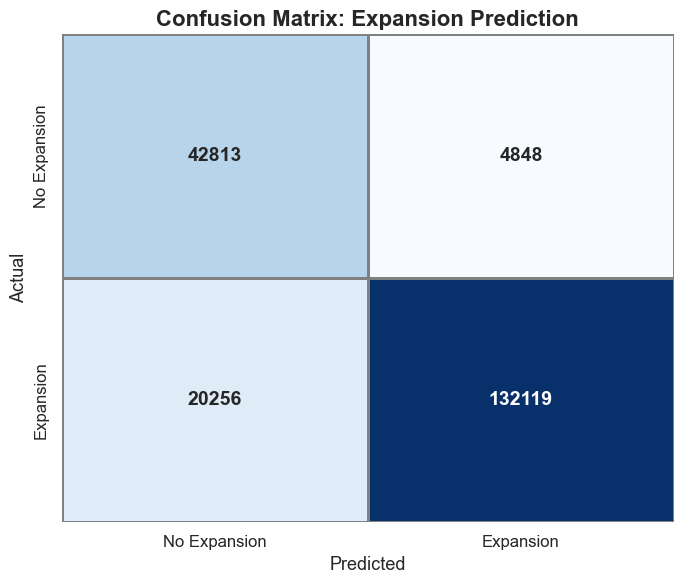

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = ["No Expansion", "Expansion"]

# Reverse gradient for cells (darkest = highest count)
values = cm.flatten()
norm_vals = (values - values.min()) / (values.max() - values.min() + 1e-9)
colors = plt.cm.Blues(norm_vals).reshape(cm.shape[0], cm.shape[1], -1)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=cm_labels, yticklabels=cm_labels,
            cbar=False, linewidths=1, linecolor="gray",
            annot_kws={"size":14, "weight":"bold"})

# Titles and labels styled like feature importance
plt.title("Confusion Matrix: Expansion Prediction", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)

# Only show y-axis gridlines for consistency
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Feature Importance

In [33]:
from sklearn.metrics import roc_auc_score

def permutation_importance(model, X, y, pre, num_feats, cat_feats, n_repeats=5):
    baseline_probs = torch.sigmoid(model(torch.tensor(pre.transform(X).astype("float32")))).detach().numpy().ravel()
    baseline_auc = roc_auc_score(y, baseline_probs)

    importances = {}
    for feat in num_feats + cat_feats:
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            X_perm[feat] = np.random.permutation(X_perm[feat].values)
            probs = torch.sigmoid(model(torch.tensor(pre.transform(X_perm).astype("float32")))).detach().numpy().ravel()
            scores.append(roc_auc_score(y, probs))
        importances[feat] = baseline_auc - np.mean(scores)
    return importances

# run on a subset to save time
importances = permutation_importance(model, X_test.sample(5000, random_state=42), y_test.sample(5000, random_state=42), pre, num_feats, cat_feats)


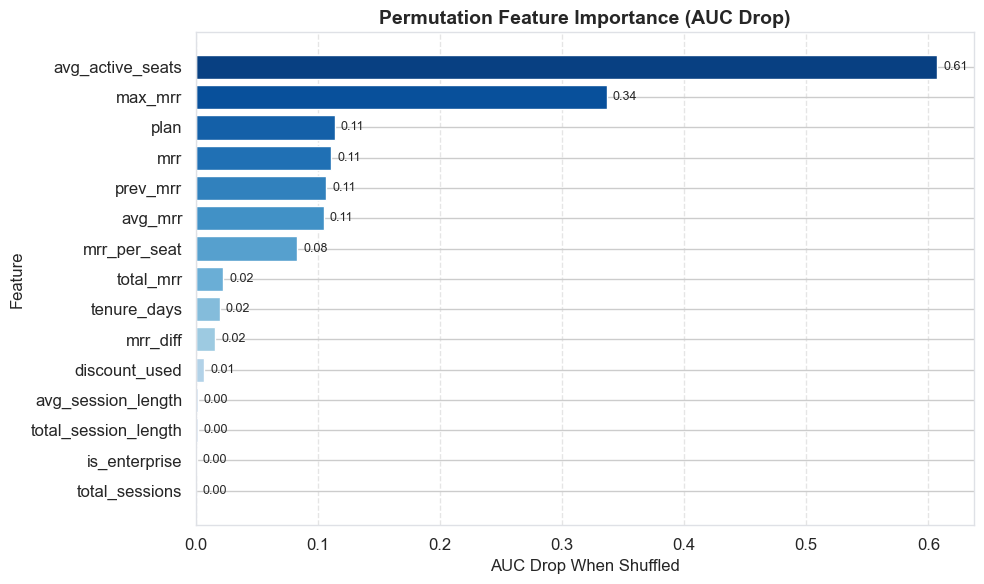

In [38]:
# sort and select top 15
imp_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*imp_sorted[:15])

# gradient colors reversed (dark at top, light at bottom)
colors = sns.color_palette("Blues", n_colors=len(features))[::-1]

plt.figure(figsize=(10,6))
bars = plt.barh(features, scores, color=colors)

# invert so most important is at the top
plt.gca().invert_yaxis()

# add value labels to bars
for bar, val in zip(bars, scores):
    plt.text(val + 0.005, bar.get_y() + bar.get_height()/2,
             f"{val:.2f}", va='center', fontsize=9)

# titles and labels
plt.title("Permutation Feature Importance (AUC Drop)", fontsize=14, weight="bold")
plt.xlabel("AUC Drop When Shuffled", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


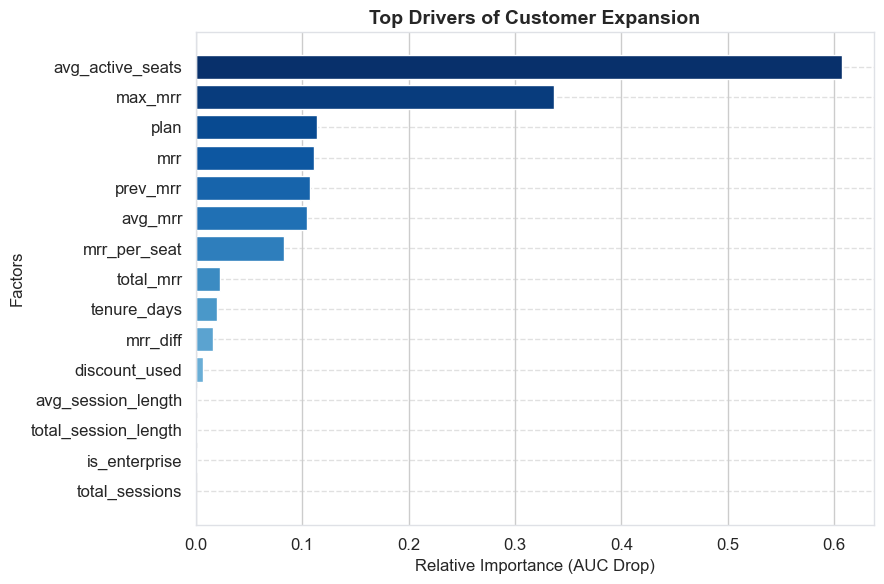

In [43]:
# Sort features by importance
imp_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*imp_sorted[:15])  # top 15

# Reverse gradient (darkest at top)
colors = plt.cm.Blues(np.linspace(1, 0.3, len(scores)))

plt.figure(figsize=(9,6))
bars = plt.barh(features, scores, color=colors)
plt.gca().invert_yaxis()

# Titles and labels for business audience
plt.title("Top Drivers of Customer Expansion", fontsize=14, weight="bold")
plt.xlabel("Relative Importance (AUC Drop)", fontsize=12)
plt.ylabel("Factors", fontsize=12)

# Show only y-axis (horizontal) gridlines
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


This chart ranks which attributes the model leans on most to predict upgrades: scrambling avg_active_seats hurts accuracy the most, so steady seat count is the strongest upgrade signal; next are revenue levels—max_mrr, current mrr, prev_mrr, avg_mrr, and mrr_per_seat—meaning accounts already spending more (or historically higher) are likelier to expand; plan has a moderate effect; while tenure_days, mrr_diff, is_enterprise, discount_used, session/usage metrics, and support_ticket_count barely change accuracy when shuffled, so they add little predictive power here. Business takeaway: focus upsell efforts on growing teams with higher spend; other signals matter less in this dataset.